## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments, predicting a binary mutated/not mutated label for each gene (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
# results_dir = Path(cfg.results_dir, 'mutation_imputed_n10_i5', 'gene').resolve()
results_dir = Path(cfg.results_dir, 'rppa_results', 'gene').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(7884, 9)
[42]
['me_450k' 'expression' 'me_27k' 'rppa']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.50000,0.075067,MAP3K1,me_450k,signal,42,train,0,gene
1,0.50000,0.052209,MAP3K1,me_450k,signal,42,test,0,gene
2,0.57241,0.120450,MAP3K1,me_450k,signal,42,cv,0,gene
3,0.66692,0.118250,MAP3K1,me_450k,signal,42,train,1,gene
4,0.48509,0.085408,MAP3K1,me_450k,signal,42,test,1,gene


In [6]:
all_results_df = pd.DataFrame()
for training_data in results_df.training_data.unique():
    data_results_df = au.compare_results(results_df[results_df.training_data == training_data],
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['training_data'] = training_data
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
all_results_df.sort_values(by='p_value').head(10)

shapes unequal for ARID2, skipping
shapes unequal for ASXL1, skipping
shapes unequal for ATM, skipping
shapes unequal for ATRX, skipping
shapes unequal for AXIN1, skipping
shapes unequal for B2M, skipping
shapes unequal for BAP1, skipping
shapes unequal for BCOR, skipping
shapes unequal for BRAF, skipping
shapes unequal for BRCA1, skipping
shapes unequal for BRCA2, skipping
shapes unequal for CARD11, skipping
shapes unequal for CASP8, skipping
shapes unequal for CDH1, skipping
shapes unequal for CDKN2A, skipping
shapes unequal for CIC, skipping
shapes unequal for CREBBP, skipping
shapes unequal for CSF1R, skipping
shapes unequal for CTNNB1, skipping
shapes unequal for DNMT1, skipping
shapes unequal for DNMT3A, skipping
shapes unequal for EGFR, skipping
shapes unequal for EP300, skipping
shapes unequal for ERBB2, skipping
shapes unequal for EZH2, skipping
shapes unequal for FBXW7, skipping
shapes unequal for FGFR2, skipping
shapes unequal for FGFR3, skipping
shapes unequal for FLT3, ski

,gene,delta_mean,p_value,corr_pval,reject_null,training_data
86,TP53,0.405645,3.771086e-09,3.356267e-07,True,expression
82,TP53,0.255192,5.630392e-09,4.842137e-07,True,me_27k
27,EGFR,0.472665,1.609974e-08,7.164386e-07,True,expression
10,ATRX,0.352355,2.584322e-08,2.274204e-06,True,rppa
4,ARID1A,0.372710,3.604503e-08,1.069336e-06,True,expression
15,BRAF,0.540453,1.331804e-07,5.859937e-06,True,rppa
71,PTEN,0.567128,1.969129e-07,4.381313e-06,True,expression
3,APC,0.576183,1.977135e-07,1.383995e-06,True,me_450k
14,BRAF,0.628842,2.767178e-07,4.925576e-06,True,expression
13,BRAF,0.502543,3.283081e-07,1.411725e-05,True,me_27k


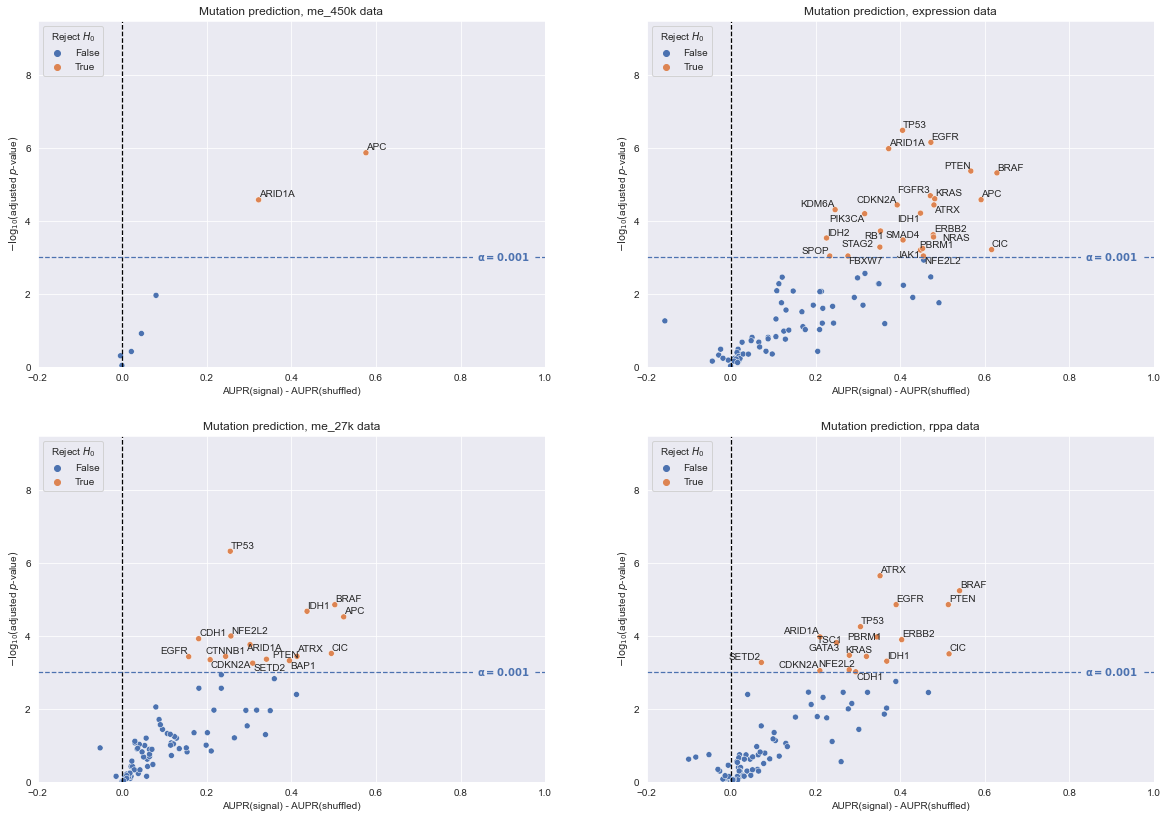

In [13]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

sns.set({'figure.figsize': (20, 14)})
fig, axarr = plt.subplots(2, 2)

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, training_data in enumerate(all_results_df.training_data.unique()):
    ax = axarr[ix // 2, ix % 2]
    data_results_df = all_results_df[all_results_df.training_data == training_data]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)')
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, {} data'.format(training_data))

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)

In [7]:
compare_results_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null
0,CTNNB1,0.227291,3.089272e-07,0.000003,True
1,ARID1B,-0.018112,1.372172e-01,0.216327,False
2,TSC1,0.226654,6.825818e-05,0.000332,True
3,CIC,0.111714,2.113956e-05,0.000120,True
4,SPOP,0.270801,2.067940e-07,0.000002,True


size 0 results array for CBL, skipping
size 0 results array for CDC73, skipping
size 0 results array for CBL, skipping
size 0 results array for GNA11, skipping
size 0 results array for CDC73, skipping
size 0 results array for GNAQ, skipping


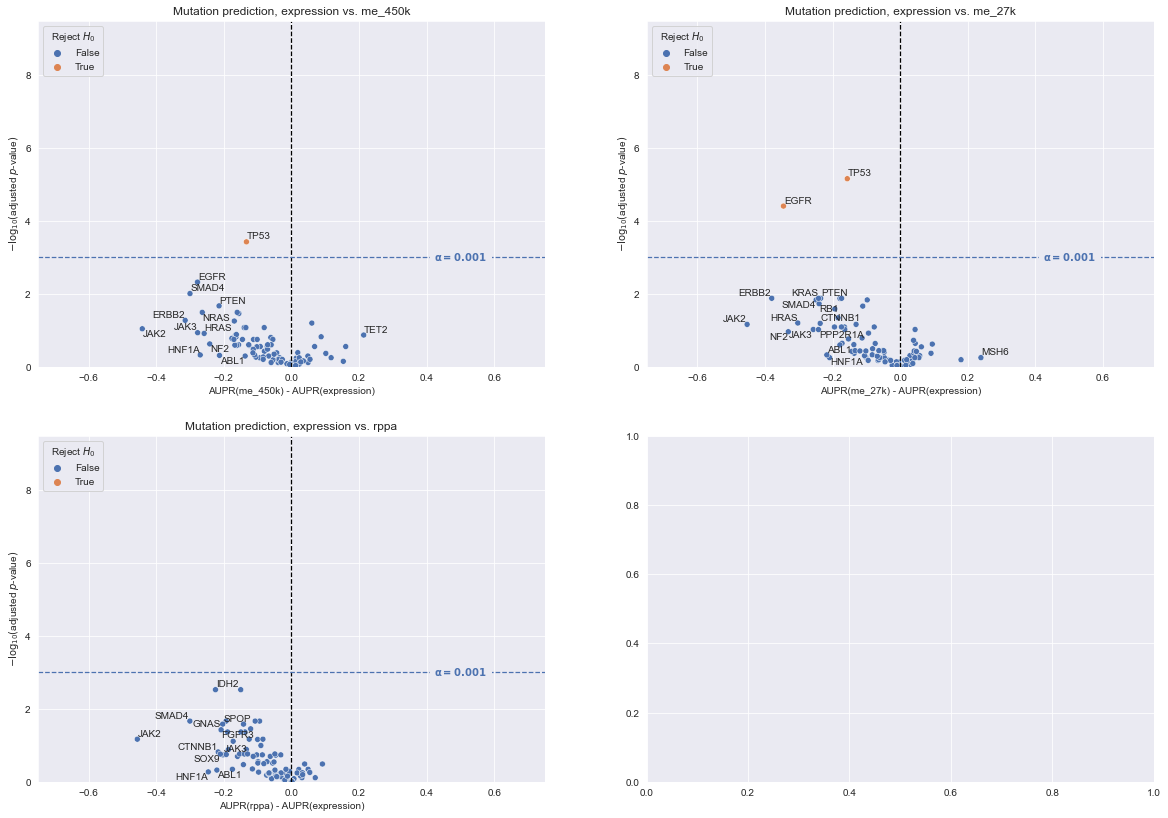

In [23]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if (point['y'] > -np.log10(0.001)) or (abs(point['x']) > 0.2):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

sns.set({'figure.figsize': (20, 14)})
fig, axarr = plt.subplots(2, 2)

# all plots should have the same axes for a fair comparison
xlim = (-0.75, 0.75)
# TODO: maybe adjust these afterward?
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

data_types = [dt for dt in all_results_df.training_data.unique() if dt != 'expression']
exp_results_df = results_df[results_df.training_data == 'expression']

for ix, training_data in enumerate(data_types):
    ax = axarr[ix // 2, ix % 2]
    data_results_df = results_df[results_df.training_data == training_data]
    compare_results_df = au.compare_results(exp_results_df,
                                            pancancer_df=data_results_df,
                                            identifier='identifier',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
    compare_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)
    sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax)

    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.5, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR({}) - AUPR(expression)'.format(training_data))
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(title=r'Reject $H_0$', loc='upper left')
    ax.set_title(r'Mutation prediction, expression vs. {}'.format(training_data))

    text_labels = label_points(compare_results_df['delta_mean'],
                               compare_results_df['nlog10_p'],
                               compare_results_df.gene,
                               ax)
    adjust_text(text_labels,
                ax=ax,
                expand_text=(1., 1.),
                lim=5)